# T81-558: Applications of Deep Neural Networks
**Class 3: Training a Neural Network**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Building the Feature Vector

Neural networks require their input to be a fixed number of columns.  This is very similar to spreadsheet data.  This input must be completely numeric.  

It is important to represent the data in a way that the neural network can train from it.  In class 6, we will see even more ways to preprocess data.  For now, we will look at several of the most basic ways to transform data for a neural network.

Before we look at specific ways to preprocess data, it is important to consider four basic types of data, as defined by [Stanley Smith Stevens](https://en.wikipedia.org/wiki/Stanley_Smith_Stevens).  These are commonly referred to as the [levels of measure](https://en.wikipedia.org/wiki/Level_of_measurement):

* Character Data (strings)
    * **Nominal** - Individual discrete items, no order. For example: color, zip code, shape.
    * **Ordinal** - Individual discrete items that can be ordered.  For example: grade level, job title, Starbucks(tm) coffee size (tall, vente, grande) 
* Numeric Data
    * **Interval** - Numeric values, no defined start.  For example, temperature.  You would never say "yesterday was twice as hot as today".
    * **Ratio** - Numeric values, clearly defined start.  For example, speed.  You would say that "The first car is going twice as fast as the second."

The following code contains several useful functions to encode the feature vector for various types of data.  Encoding data:

* **encode_text_dummy** - Encode text fields, such as the iris species as a single field for each class.  Three classes would become "0,0,1" "0,1,0" and "1,0,0". Encode non-target predictors this way. Good for nominal.
* **encode_text_index** - Encode text fields, such as the iris species as a single numeric field as "0" "1" and "2".  Encode the target field for a classification this way.  Good for nominal.
* **encode_numeric_zscore** - Encode numeric values as a z-score.  Neural networks deal well with "centered" fields, zscore is usually a good starting point for interval/ratio.

*Ordinal values can be encoded as dummy or index.  Later we will see a more advanced means of encoding*

Dealing with missing data:

* **missing_median** - Fill all missing values with the median value.

Creating the final feature vector:

* **to_xy** - Once all fields are numeric, this function can provide the x and y matrixes that are used to fit the neural network.

Other utility functions:

* **hms_string** - Print out an elapsed time string.
* **chart_regression** - Display a chart to show how well a regression performs.


In [18]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type

    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Training with a Validation Set and Early Stopping

**Overfitting** occurs when a neural network is trained to the point that it begins to memorize rather than generalize.  

![Training vs Validation Error for Overfitting](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_training_val.png "Training vs Validation Error for Overfitting")

It is important to segment the original dataset into several datasets:

* **Training Set**
* **Validation Set**
* **Holdout Set**

There are several different ways that these sets can be constructed.  The following programs demonstrate some of these.

The first method is a training and validation set.  The training data are used to train the neural network until the validation set no longer improves.  This attempts to stop at a near optimal training point.  This method will only give accurate "out of sample" predictions for the validation set, this is usually 20% or so of the data.  The predictions for the training data will be overly optimistic, as these were the data that the neural network was trained on.  

![Training with a Validation Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_1_train_val.png "Training with a Validation Set")


In [19]:
import os
import pandas as pd
from sklearn.cross_validation import train_test_split
import tensorflow.contrib.learn as skflow
import numpy as np

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
encode_numeric_zscore(df,'petal_w')
encode_numeric_zscore(df,'petal_l')
encode_numeric_zscore(df,'sepal_w')
encode_numeric_zscore(df,'sepal_l')
species = encode_text_index(df,"species")
num_classes = len(species)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'species')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
    # as much as I would like to use 42, it gives a perfect result, and a boring confusion matrix!
    
# Create a deep neural network with 3 hidden layers of 10, 20, 10
classifier = skflow.TensorFlowDNNClassifier(hidden_units=[5, 20, 10], n_classes=num_classes,
    steps=10000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50, n_classes=num_classes)
    
# Fit/train neural network
classifier.fit(x_train, y_train, monitor=early_stop)
    

/usr/local/lib/python3.4/dist-packages/tensorflow/contrib/learn/python/learn/io/data_feeder.py:281: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)


Step #50, epoch #12, avg. train loss: 0.53108, avg. val loss: 0.53152
Step #100, epoch #25, avg. train loss: 0.10657, avg. val loss: 0.16325
Step #150, epoch #37, avg. train loss: 0.05762, avg. val loss: 0.13760
Step #200, epoch #50, avg. train loss: 0.05041, avg. val loss: 0.15182
Step #250, epoch #62, avg. train loss: 0.03561, avg. val loss: 0.14002
Step #300, epoch #75, avg. train loss: 0.04022, avg. val loss: 0.13479
Step #350, epoch #87, avg. train loss: 0.02812, avg. val loss: 0.14996
Step #400, epoch #100, avg. train loss: 0.02655, avg. val loss: 0.14363
Step #450, epoch #112, avg. train loss: 0.02942, avg. val loss: 0.14883
Step #500, epoch #125, avg. train loss: 0.03025, avg. val loss: 0.14984
Step #550, epoch #137, avg. train loss: 0.02500, avg. val loss: 0.13992
Step #600, epoch #150, avg. train loss: 0.02287, avg. val loss: 0.14733
Step #650, epoch #162, avg. train loss: 0.02709, avg. val loss: 0.15769


Stopping. Best step:
 step 464 with loss 0.018344204872846603


TensorFlowDNNClassifier(batch_size=32, class_weight=None, clip_gradients=5.0,
            config=None, continue_training=False, dropout=None,
            hidden_units=[5, 20, 10], learning_rate=0.1, n_classes=3,
            optimizer='Adagrad', steps=10000, verbose=1)

# Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$ accuracy = \frac{\textit{#} \ correct}{N} $

Where $N$ is the size of the evaluted set (training or validation).

In [20]:
from sklearn import metrics

# Evaluate success using accuracy
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9210526315789473


# Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers.

For any scikit-learn model there are two ways to get a prediction:

* **predict** - In the case of classification output the numeric id of the predicted class.  For regression, this is simply the prediction.
* **predict_proba** - In the case of classification output the probability of each of the classes.  Not used for regression.

The following code shows the output of predict_proba:


In [21]:
pred = classifier.predict_proba(x_test)

np.set_printoptions(precision=4)

print("Numpy array of predictions")
print(pred[0:5])

print("As percent probability")
(pred[0:5]*100).astype(int)

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

Numpy array of predictions
[[  9.9992e-01   8.0931e-05   1.1739e-14]
 [  9.9985e-01   1.4813e-04   3.7525e-12]
 [  2.6230e-05   8.2637e-01   1.7360e-01]
 [  9.9992e-01   7.7227e-05   4.7578e-14]
 [  9.9979e-01   2.1312e-04   1.4006e-14]]
As percent probability
Log loss score: 0.1745572018822043


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$ \text{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

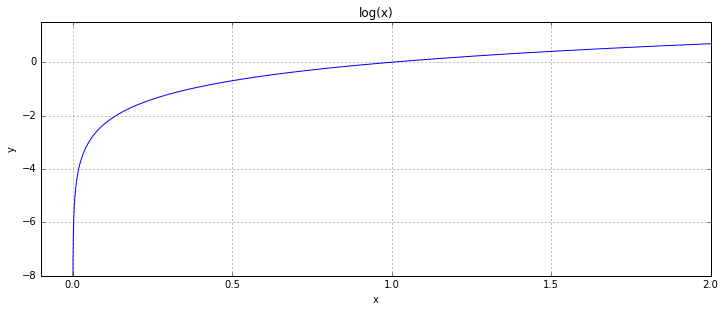

In [22]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

t = arange(0.0, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
#t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

# Evaluating Regression Results

Regression results are evaluated differently than classification.  Consider the following code that trains a neural network for the [MPG dataset](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/datasets_mpg.ipynb). 

In [23]:
import tensorflow.contrib.learn as skflow
from sklearn.cross_validation import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,['mpg'])

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
regressor = skflow.TensorFlowDNNRegressor(hidden_units=[50, 25, 10], steps=5000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50)

# Fit/train neural network
regressor.fit(x_train, y_train, monitor=early_stop)


Step #50, epoch #5, avg. train loss: 40.25010, avg. val loss: 35.26281
Step #100, epoch #10, avg. train loss: 6.67342, avg. val loss: 6.36329
Step #150, epoch #15, avg. train loss: 3.44723, avg. val loss: 3.21085
Step #200, epoch #20, avg. train loss: 1.99451, avg. val loss: 1.88279
Step #250, epoch #25, avg. train loss: 1.46245, avg. val loss: 1.39983
Step #300, epoch #30, avg. train loss: 1.22336, avg. val loss: 1.14907


Stopping. Best step:
 step 109 with loss 0.603066623210907


TensorFlowDNNRegressor(batch_size=32, clip_gradients=5.0, config=None,
            continue_training=False, dropout=None,
            hidden_units=[50, 25, 10], learning_rate=0.1, n_classes=0,
            optimizer='Adagrad', steps=5000, verbose=1)

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [24]:
pred = regressor.predict(x_test)
# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 2.2958037853240967


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome.

$ \text{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [25]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 1.5151909589767456


# Training with Cross Validation

Cross validation uses a number of folds, and multiple models, to generate out of sample predictions on the entire dataset.  It is important to note that there will be one model (neural network) for each fold. Each model contributes part of the final out-of-sample prediction.

![K-Fold Crossvalidation](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_1_kfold.png "K-Fold Crossvalidation")

For new data, which is data not present in the training set, predictions from the fold models can be handled in several ways.

* Choose the model that had the highest validation score as the final model.
* Preset new data to the 5 models and average the result (this is an [enesmble](https://en.wikipedia.org/wiki/Ensemble_learning)).
* Retrain a new model (using the same settings as the crossvalidation) on the entire dataset.  Train for as many steps, and with the same hidden layer structure.

The following code trains the MPG dataset using a 5-fold cross validation.  The expected performance of a neural network, of the type trained here, would be the score for the generated out-of-sample predictions.

In [37]:
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.cross_validation import KFold

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
x,y = to_xy(df,['mpg'])

# Cross validate
kf = KFold(len(x), n_folds=5)
    
oos_y = []
oos_pred = []
fold = 1
for train, test in kf:        
    print("Fold #{}".format(fold))
    fold+=1
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
        
    # Create a deep neural network with 3 hidden layers of 10, 20, 10
    regressor = skflow.TensorFlowDNNRegressor(hidden_units=[10, 20, 10], steps=500)

    # Early stopping
    early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
        early_stopping_rounds=200, print_steps=50)
        
    # Fit/train neural network
    regressor.fit(x, y, monitor=early_stop)

    # Add the predictions to the oos prediction list
    pred = regressor.predict(x_test)
    
    for i in range(len(pred)):
        print("{} {}".format(pred[i],y_test[i]))
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)


Fold #1
Step #50, epoch #3, avg. train loss: 26.28529, avg. val loss: 21.69395
Step #100, epoch #7, avg. train loss: 4.14423, avg. val loss: 3.98790
Step #150, epoch #11, avg. train loss: 2.81061, avg. val loss: 2.71588
Step #200, epoch #15, avg. train loss: 2.04829, avg. val loss: 1.96061
Step #250, epoch #19, avg. train loss: 1.44071, avg. val loss: 1.36827
Step #300, epoch #23, avg. train loss: 1.16614, avg. val loss: 1.11980
Step #350, epoch #26, avg. train loss: 0.95145, avg. val loss: 0.91015
Step #400, epoch #30, avg. train loss: 0.83353, avg. val loss: 0.79693
Step #450, epoch #34, avg. train loss: 0.70365, avg. val loss: 0.68443
Step #500, epoch #38, avg. train loss: 0.62153, avg. val loss: 0.59630
[ 32.7134] [ 33.]
[ 27.4831] [ 28.]
[ 18.7998] [ 19.]
[ 13.2602] [ 13.]
[ 13.9047] [ 14.]
[ 26.6593] [ 27.]
[ 23.558] [ 24.]
[ 12.754] [ 13.]
[ 16.6831] [ 17.]
[ 20.6262] [ 21.]
[ 14.7108] [ 15.]
[ 37.5354] [ 38.]
[ 25.7457] [ 26.]
[ 14.8516] [ 15.]
[ 24.5913] [ 25.]
[ 11.8729] [ 12

# Training with Cross Validation and a Holdout Set

If you have a considerable amount of data, it is always valuable to set aside a holdout set before you crossvalidate.  This hold out set will be the final evaluation before you make use of your model for its real-world use.

![Cross Validation and a Holdout Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_hold_train_val.png "Cross Validation and a Holdout Set")

The following program makes use of a hodlout set, and then still cross validates.  

In [27]:
import tensorflow.contrib.learn as skflow
from sklearn.cross_validation import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.cross_validation import KFold

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-holdout.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
x,y = to_xy(df,['mpg'])


# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 


# Cross validate
kf = KFold(len(x_main), n_folds=5)
    
oos_y = []
oos_pred = []
fold = 1
for train, test in kf:        
    print("Fold #{}".format(fold))
    fold+=1
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
        
    # Create a deep neural network with 3 hidden layers of 10, 20, 10
    regressor = skflow.TensorFlowDNNRegressor(hidden_units=[10, 20, 10], steps=500)

    # Early stopping
    early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
        early_stopping_rounds=200, print_steps=50)
        
    # Fit/train neural network
    regressor.fit(x, y, monitor=early_stop)

    # Add the predictions to the OOS prediction list
    pred = regressor.predict(x_test)
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print()
print("Cross-validated score (RMSE): {}".format(score))    
    
# Write the cross-validated prediction
holdout_pred = regressor.predict(x_holdout)
score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print("Holdout score (RMSE): {}".format(score))    


Fold #1
Step #50, epoch #3, avg. train loss: 26.28529, avg. val loss: 24.36897
Step #100, epoch #7, avg. train loss: 4.14423, avg. val loss: 4.49891
Step #150, epoch #11, avg. train loss: 2.81061, avg. val loss: 3.08176
Step #200, epoch #15, avg. train loss: 2.04829, avg. val loss: 2.23625
Step #250, epoch #19, avg. train loss: 1.44071, avg. val loss: 1.54594
Step #300, epoch #23, avg. train loss: 1.16614, avg. val loss: 1.26415
Step #350, epoch #26, avg. train loss: 0.95145, avg. val loss: 1.02359
Step #400, epoch #30, avg. train loss: 0.83353, avg. val loss: 0.89303
Step #450, epoch #34, avg. train loss: 0.70365, avg. val loss: 0.76433
Step #500, epoch #38, avg. train loss: 0.62153, avg. val loss: 0.66763
Fold score (RMSE): 0.47584784030914307
Fold #2
Step #50, epoch #3, avg. train loss: 26.28529, avg. val loss: 23.21247
Step #100, epoch #7, avg. train loss: 4.14423, avg. val loss: 4.09952
Step #150, epoch #11, avg. train loss: 2.81061, avg. val loss: 2.73427
Step #200, epoch #15, av

# How Kaggle Competitions are Scored

[Kaggle](https://www.kaggle.com/) is a platform for competitive data science. Competitions are posted onto Kaggle by companies seeking the best model for their data.  Competing in a Kaggle competition is quite a bit of work, I've [competed in one Kaggle competition](https://www.kaggle.com/jeffheaton).   

Kaggle awards "tiers", such as:

* Kaggle Grandmaster
* Kaggle Master
* Kaggle Expert

Your [tier](https://www.kaggle.com/progression) is based on your performance in past competitions.  

To compete in Kaggle you simply provide predictions for a dataset that they post.  You do not need to submit any code.  Your prediction output will place you onto the [leaderboard of a competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/leaderboard/public).

![How Kaggle Competitions are Scored](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_kaggle.png "How Kaggle Competitions are Scored")

An original dataset is sent to Kaggle by the company.  From this dataset, Kaggle posts public data that includes "train" and "test.  For the "train" data, the outcomes (y) are provided.  For the test data, no outcomes are provided.  Your submission file contains your predictions for the "test data".  When you submit your results, Kaggle will calculate a score on part of your prediction data.  They do not publish want part of the submission data are used for the public and private leaderboard scores (this is a secret to prevent overfitting).  While the competition is still running, Kaggle publishes the public leaderboard ranks.  Once the competition ends, the private leaderboard is revealed to designate the true winners.  Due to overfitting, there is sometimes an upset in positions when the final private leaderboard is revealed.  

# Managing Hyperparameters

There are many different settings that you can use for a neural network.  These can affect performance.  The following code changes some of these, beyond their default values:

Step #50, epoch #5, avg. train loss: 116.54040, avg. val loss: 112.99763
Step #100, epoch #10, avg. train loss: 89.96941, avg. val loss: 87.74393
Step #150, epoch #15, avg. train loss: 85.77597, avg. val loss: 82.47623
Step #200, epoch #20, avg. train loss: 107.34383, avg. val loss: 105.91818
Step #250, epoch #25, avg. train loss: 260.06281, avg. val loss: 255.98512
Step #300, epoch #30, avg. train loss: 400.08148, avg. val loss: 385.52271
Step #350, epoch #35, avg. train loss: 327.46240, avg. val loss: 332.21866
Step #400, epoch #40, avg. train loss: 313.56699, avg. val loss: 296.57434
Step #450, epoch #45, avg. train loss: 318.39151, avg. val loss: 307.89630
Step #500, epoch #50, avg. train loss: 306.70233, avg. val loss: 293.10837
Final score (RMSE): 4.693182945251465


Stopping. Best step:
 step 320 with loss 4.109667778015137


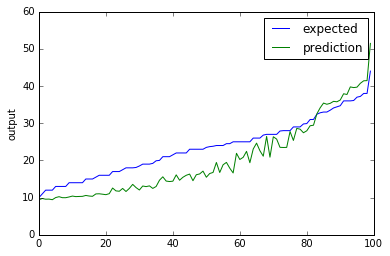

In [28]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore
import matplotlib.pyplot as plt

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,['mpg'])

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
regressor = skflow.TensorFlowDNNRegressor(
    hidden_units=[50, 25, 10], 
    batch_size = 32,
    optimizer='SGD', 
    learning_rate=0.1,  
    steps=5000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50)

# Fit/train neural network
regressor.fit(x_train, y_train, monitor=early_stop)

# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred,y_test)


# Grid Search

Finding the right set of hyperparameters can be a large task.  Often computational power is thrown at this job.  The scikit-learn grid search makes use of your computer's CPU cores to try every one of a defined number of hyperparameters to see which gets the best score.

The following code shows how many CPU cores are available to Python:

In [29]:
import multiprocessing

print("Your system has {} cores.".format(multiprocessing.cpu_count()))

Your system has 16 cores.


The following code performs a grid search.  Your system is queried for the number of cores available they are used to scan through the combinations of hyperparameters that you specify.

Using 1 cores.
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Step #50, epoch #2, avg. train loss: 117.61263, avg. val loss: 112.52674
Step #100, epoch #4, avg. train loss: 85.18143, avg. val loss: 88.04768
Step #150, epoch #6, avg. train loss: 85.25250, avg. val loss: 83.23692
Step #200, epoch #8, avg. train loss: 84.87563, avg. val loss: 83.49469
Step #250, epoch #10, avg. train loss: 111.80933, avg. val loss: 112.94936
Step #300, epoch #12, avg. train loss: 143.66399, avg. val loss: 150.81792


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 121.87177, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 91.63583, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 85.63168, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 122.88097, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 132.26941, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 122.21429, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 113.44821, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 89.88203, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 90.21741, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 103.69730, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 94.02605, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 123.04208, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 61.50158, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 9.21131, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 6.62630, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.72712, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 5.34260, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 4.67256, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 16.41841, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 8.58952, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 6.38897, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.32702, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 5.20406, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 4.93201, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 16.23615, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 8.38101, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 6.29617, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.59181, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 5.02868, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 4.88766, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 52.81164, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 10.55432, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 7.15133, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 3.65439, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 1.48652, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 0.60762, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 47.78577, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 9.84935, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 7.42973, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 4.75682, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 2.72797, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 1.17476, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #2, avg. train loss: 49.52269, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 10.90975, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 8.23848, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.26982, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 2.76959, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 0.93841, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 91.19921, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 88.60535, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 82.71747, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 87.88103, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 209.92661, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 335.36008, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 150.08495, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 89.40485, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 87.85256, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 89.70992, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 127.02207, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 192.67430, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 153.31351, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 90.26623, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 87.19946, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 83.90716, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 106.50768, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 185.50458, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 62.92568, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 8.15044, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 6.27310, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 5.60482, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 5.50561, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 4.76665, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 15.45518, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 8.10728, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 6.34476, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 5.52079, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 5.04669, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 4.77823, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 15.61418, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 7.67019, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 6.40806, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 5.78763, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 5.21622, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 4.97477, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 51.01530, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 9.98542, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 5.80767, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 2.73364, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 0.91427, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 0.42507, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 47.57145, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 9.96222, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 6.55372, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 3.71244, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 1.39550, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 0.60042, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #3, avg. train loss: 49.37324, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 10.46622, avg. val loss: nan
Step #150, epoch #11, avg. train loss: 6.55805, avg. val loss: nan
Step #200, epoch #15, avg. train loss: 3.55950, avg. val loss: nan
Step #250, epoch #19, avg. train loss: 1.35272, avg. val loss: nan
Step #300, epoch #23, avg. train loss: 0.49528, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 89.73451, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 90.25979, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 84.47258, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 112.24527, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 206.69354, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 278.86163, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 166.13017, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 92.52643, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 83.76660, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 98.10649, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 156.34482, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 257.36945, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 151.14911, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 94.39133, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 87.51699, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 109.70860, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 223.52579, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 143.97682, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 50.72849, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 8.30047, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 6.33735, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 5.85491, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 5.18009, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 4.82449, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 16.08327, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 8.51062, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 6.14985, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 5.34735, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 4.74940, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 4.46643, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 16.68110, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 8.31094, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 6.15864, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 5.64206, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 4.68322, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 4.50705, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 50.39196, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 9.64381, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 5.59810, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 2.51834, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 0.72687, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 0.40850, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 47.67574, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 9.44921, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 4.80503, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 1.94174, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 0.71709, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 0.46327, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074


Step #50, epoch #7, avg. train loss: 49.50134, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 9.81375, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 5.39176, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 2.54223, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 0.77944, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 0.42825, avg. val loss: nan


Stopping. Best step:
 step 115 with loss 4.446322441101074
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.1min finished


Step #50, epoch #5, avg. train loss: 49.15835, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 9.54381, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 5.08737, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 1.99072, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 0.60585, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 0.44362, avg. val loss: nan
Final score (RMSE): 0.7907052040100098
Final options: {'batch_size': 32, 'learning_rate': 0.001}


Stopping. Best step:
 step 115 with loss 4.446322441101074


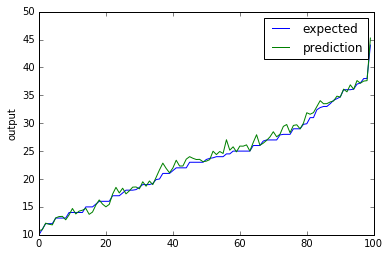

Elapsed time: 0:01:05.73


In [31]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore
from sklearn.grid_search import GridSearchCV
import multiprocessing
import time
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

def main():
    path = "./data/"

    filename_read = os.path.join(path,"auto-mpg.csv")
    df = pd.read_csv(filename_read,na_values=['NA','?'])
    
    start_time = time.time()

    # create feature vector
    missing_median(df, 'horsepower')
    df.drop('name',1,inplace=True)
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_text_dummy(df, 'origin')

    # Encode to a 2D matrix for training
    x,y = to_xy(df,['mpg'])

    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.25, random_state=42)

    # The hyperparameters specified here will be searched.  Every combination.
    param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'batch_size': [8, 16, 32]
    }

    # Create a deep neural network.  The hyperparameters specified here remain fixed.
    model = skflow.TensorFlowDNNRegressor(
        hidden_units=[50, 25, 10], 
        batch_size = 32,
        optimizer='SGD', 
        steps=5000)

    # Early stopping
    early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
        early_stopping_rounds=200, print_steps=50)
    
    # Startup grid search
    threads = 1# multiprocessing.cpu_count()
    print("Using {} cores.".format(threads))
    regressor = GridSearchCV(model, verbose=True, n_jobs=threads, 
                             param_grid=param_grid,fit_params={'monitor':early_stop})

    # Fit/train neural network
    regressor.fit(x_train, y_train)

    # Measure RMSE error.  RMSE is common for regression.
    pred = regressor.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Final score (RMSE): {}".format(score))
    print("Final options: {}".format(regressor.best_params_))

    # Plot the chart
    chart_regression(pred,y_test)
    
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))


# Allow windows to multi-thread (unneeded on advanced OS's)
# See: https://docs.python.org/2/library/multiprocessing.html
if __name__ == '__main__':
    main()



The best combination of hyperparameters are displayed.

# Random Search

It is also possable to conduct a random search.  The random search is similar to the grid search, except that the entire search space is not used.  Rather, random points in the search space are tried.  For a random search you must specify the number of hyperparameter iterations (n_iter) to try.

Using 1 cores.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Step #50, epoch #5, avg. train loss: 119.03162, avg. val loss: 113.05585
Step #100, epoch #11, avg. train loss: 91.39496, avg. val loss: 87.70108
Step #150, epoch #16, avg. train loss: 84.16493, avg. val loss: 82.91374
Step #200, epoch #22, avg. train loss: 110.80615, avg. val loss: 108.89703
Step #250, epoch #27, avg. train loss: 217.65082, avg. val loss: 209.06215
Step #300, epoch #33, avg. train loss: 281.74396, avg. val loss: 271.19662


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #5, avg. train loss: 194.77887, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 464.68176, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 508.88062, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 484.13281, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 556.06689, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 579.09985, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #5, avg. train loss: 278.04095, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 88.87047, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 84.49898, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 81.49370, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 85.08032, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 95.25882, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 46.10161, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 9.21131, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 6.62630, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.72712, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 5.34260, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 4.67256, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 15.46994, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 8.58952, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 6.38897, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.32702, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 5.20406, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 4.93201, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 15.19263, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 8.38101, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 6.29617, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 5.59181, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 5.02868, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 4.88766, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #7, avg. train loss: 15.78159, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 8.28783, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 6.49213, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 5.75834, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 5.12233, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 4.76318, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #7, avg. train loss: 14.72083, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 8.41516, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 6.22204, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 5.39221, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 4.83101, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 4.42398, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #7, avg. train loss: 15.08047, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 7.79407, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 6.57559, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 5.36187, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 5.08710, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 4.71129, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #6, avg. train loss: 85.77355, avg. val loss: nan
Step #100, epoch #12, avg. train loss: 90.22788, avg. val loss: nan
Step #150, epoch #18, avg. train loss: 89.28012, avg. val loss: nan
Step #200, epoch #25, avg. train loss: 141.62619, avg. val loss: nan
Step #250, epoch #31, avg. train loss: 263.86884, avg. val loss: nan
Step #300, epoch #37, avg. train loss: 317.06161, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #6, avg. train loss: 171.49805, avg. val loss: nan
Step #100, epoch #12, avg. train loss: 88.97533, avg. val loss: nan
Step #150, epoch #18, avg. train loss: 83.92780, avg. val loss: nan
Step #200, epoch #25, avg. train loss: 88.47162, avg. val loss: nan
Step #250, epoch #31, avg. train loss: 163.38989, avg. val loss: nan
Step #300, epoch #37, avg. train loss: 259.68347, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #6, avg. train loss: 161.79581, avg. val loss: nan
Step #100, epoch #12, avg. train loss: 94.75294, avg. val loss: nan
Step #150, epoch #18, avg. train loss: 88.48658, avg. val loss: nan
Step #200, epoch #25, avg. train loss: 146.03804, avg. val loss: nan
Step #250, epoch #31, avg. train loss: 315.62747, avg. val loss: nan
Step #300, epoch #37, avg. train loss: 385.94479, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 181.98497, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 88.39139, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 86.26452, avg. val loss: nan
Step #200, epoch #9, avg. train loss: 84.44620, avg. val loss: nan
Step #250, epoch #11, avg. train loss: 78.79990, avg. val loss: nan
Step #300, epoch #13, avg. train loss: 115.07505, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 133.81071, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 271.67899, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 469.61261, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 267.93613, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 256.91455, avg. val loss: nan
Step #300, epoch #13, avg. train loss: 215.50307, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 137.73425, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 103.73207, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 100.02467, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 98.61755, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 96.03592, avg. val loss: nan
Step #300, epoch #13, avg. train loss: 80.96527, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 106.72546, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 85.18143, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 85.25250, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 84.87563, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 111.80933, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 143.66399, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 125.36861, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 91.63583, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 85.63168, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 122.88097, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 132.26941, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 122.21429, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #2, avg. train loss: 111.61111, avg. val loss: nan
Step #100, epoch #4, avg. train loss: 89.88203, avg. val loss: nan
Step #150, epoch #6, avg. train loss: 90.21741, avg. val loss: nan
Step #200, epoch #8, avg. train loss: 103.69730, avg. val loss: nan
Step #250, epoch #10, avg. train loss: 94.02605, avg. val loss: nan
Step #300, epoch #12, avg. train loss: 123.04208, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #3, avg. train loss: 71.46045, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 7.74066, avg. val loss: nan
Step #150, epoch #10, avg. train loss: 6.72546, avg. val loss: nan
Step #200, epoch #14, avg. train loss: 5.93429, avg. val loss: nan
Step #250, epoch #17, avg. train loss: 5.20244, avg. val loss: nan
Step #300, epoch #21, avg. train loss: 4.89661, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #3, avg. train loss: 14.40589, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 7.98830, avg. val loss: nan
Step #150, epoch #10, avg. train loss: 6.61255, avg. val loss: nan
Step #200, epoch #14, avg. train loss: 5.57532, avg. val loss: nan
Step #250, epoch #17, avg. train loss: 5.36095, avg. val loss: nan
Step #300, epoch #21, avg. train loss: 4.51519, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #3, avg. train loss: 14.93016, avg. val loss: nan
Step #100, epoch #7, avg. train loss: 7.50097, avg. val loss: nan
Step #150, epoch #10, avg. train loss: 6.26154, avg. val loss: nan
Step #200, epoch #14, avg. train loss: 5.33556, avg. val loss: nan
Step #250, epoch #17, avg. train loss: 4.81537, avg. val loss: nan
Step #300, epoch #21, avg. train loss: 5.01971, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #4, avg. train loss: 16.68076, avg. val loss: nan
Step #100, epoch #8, avg. train loss: 7.31574, avg. val loss: nan
Step #150, epoch #12, avg. train loss: 6.45510, avg. val loss: nan
Step #200, epoch #16, avg. train loss: 6.00557, avg. val loss: nan
Step #250, epoch #20, avg. train loss: 5.20524, avg. val loss: nan
Step #300, epoch #25, avg. train loss: 4.69878, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #4, avg. train loss: 13.62711, avg. val loss: nan
Step #100, epoch #8, avg. train loss: 7.99741, avg. val loss: nan
Step #150, epoch #12, avg. train loss: 6.06766, avg. val loss: nan
Step #200, epoch #16, avg. train loss: 5.25168, avg. val loss: nan
Step #250, epoch #20, avg. train loss: 4.76334, avg. val loss: nan
Step #300, epoch #25, avg. train loss: 4.73252, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #4, avg. train loss: 15.16447, avg. val loss: nan
Step #100, epoch #8, avg. train loss: 8.50342, avg. val loss: nan
Step #150, epoch #12, avg. train loss: 6.39463, avg. val loss: nan
Step #200, epoch #16, avg. train loss: 5.53198, avg. val loss: nan
Step #250, epoch #20, avg. train loss: 5.05940, avg. val loss: nan
Step #300, epoch #25, avg. train loss: 4.76049, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #5, avg. train loss: 16.45395, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 7.75139, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 6.65841, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 5.48109, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 5.22986, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 4.80384, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #5, avg. train loss: 15.43036, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 7.79939, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 5.97565, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 5.34746, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 4.57847, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 4.41130, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #5, avg. train loss: 16.12781, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 8.16816, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 6.34365, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 5.69614, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 5.05360, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 4.51153, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #7, avg. train loss: 82.24306, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 91.06400, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 84.55318, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 110.43718, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 214.32616, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 258.06039, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #7, avg. train loss: 176.02786, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 88.70111, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 85.22195, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 116.25922, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 221.83266, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 266.50519, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086


Step #50, epoch #7, avg. train loss: 171.28738, avg. val loss: nan
Step #100, epoch #14, avg. train loss: 92.84826, avg. val loss: nan
Step #150, epoch #21, avg. train loss: 86.90685, avg. val loss: nan
Step #200, epoch #28, avg. train loss: 98.37138, avg. val loss: nan
Step #250, epoch #35, avg. train loss: 250.48248, avg. val loss: nan
Step #300, epoch #42, avg. train loss: 298.08206, avg. val loss: nan


Stopping. Best step:
 step 121 with loss 9.178274154663086
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


Step #50, epoch #5, avg. train loss: 120.32302, avg. val loss: nan
Step #100, epoch #10, avg. train loss: 8.02931, avg. val loss: nan
Step #150, epoch #15, avg. train loss: 6.32783, avg. val loss: nan
Step #200, epoch #20, avg. train loss: 5.44892, avg. val loss: nan
Step #250, epoch #25, avg. train loss: 5.01778, avg. val loss: nan
Step #300, epoch #30, avg. train loss: 4.60000, avg. val loss: nan
Final score (RMSE): 2.4620187282562256
Final options: {'batch_size': 31, 'learning_rate': 0.01}


Stopping. Best step:
 step 121 with loss 9.178274154663086


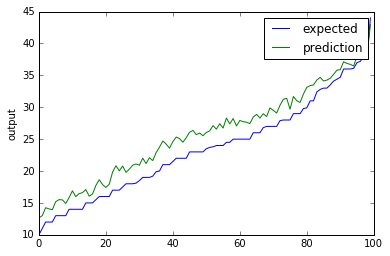

Elapsed time: 0:01:13.17


In [35]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV
import multiprocessing
import time
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

def main():
    path = "./data/"

    filename_read = os.path.join(path,"auto-mpg.csv")
    df = pd.read_csv(filename_read,na_values=['NA','?'])
    
    start_time = time.time()

    # create feature vector
    missing_median(df, 'horsepower')
    df.drop('name',1,inplace=True)
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_text_dummy(df, 'origin')

    # Encode to a 2D matrix for training
    x,y = to_xy(df,['mpg'])

    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.25, random_state=42)

    # The hyperparameters specified here will be searched. A random sample will be searched.
    param_dist = {
        'learning_rate': [0.1, 0.01, 0.001],
        'batch_size': sp_randint(4, 32),
    }


    model = skflow.TensorFlowDNNRegressor(
        hidden_units=[50, 25, 10], 
        batch_size = 32,
        optimizer='SGD', 
        steps=5000)

    # Early stopping
    early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
        early_stopping_rounds=200, print_steps=50)
    
    # Random search
    threads = 1 #multiprocessing.cpu_count()
    print("Using {} cores.".format(threads))
    regressor = RandomizedSearchCV(model, verbose=True, n_iter = 10,
            n_jobs=threads, param_distributions=param_dist, 
            fit_params={'monitor':early_stop})

    # Fit/train neural network
    regressor.fit(x_train, y_train)

    # Measure RMSE error.  RMSE is common for regression.
    pred = regressor.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Final score (RMSE): {}".format(score))
    print("Final options: {}".format(regressor.best_params_))

    # Plot the chart
    chart_regression(pred,y_test)
    
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))


# Allow windows to multi-thread (unneeded on advanced OS's)
# See: https://docs.python.org/2/library/multiprocessing.html
if __name__ == '__main__':
    main()
